# How to combine spectra without interpolation.

A notebook to support and illustrate ideas in a forthcoming paper.

## Authors:
- **David W Hogg** (NYU) (MPIA) (Flatiron)
- **Andy Casey** (Monash)

## License:
Copyright 2022 the authors. This code is licensed for re-use under the open-source *MIT License*. See the file `LICENSE` for details.

## Bugs:
- Uses `np.random.seed()` and not a random number generator object.
- Sometimes uses `j` where it should use `i`; notation should match the *LaTeX* file!
- *Sign* and *name* of *Delta x_i* not used correctly in written paper?
- Currently the text doesn't explain the data generation process quite correctly (it involves an `exp()` call).
- Plotting code contains repeated magic numbers and settings (like `ec = "none"`).
- Doesn't currently use any inverse variances or data weights.

## Stretch goals:
- Execute on real individual-exposure *SDSS-V APOGEE* data, perhaps?

In [32]:
# imports and initialize seeds, fundamental constants
import numpy as np
import pylab as plt
import scipy.interpolate as interp
np.random.seed(17)
c = 299792458. # m / s
sqrt2pi = np.sqrt(2. * np.pi)

In [33]:
# plotting defaults
# has to be in its own cell?
plt.rc('figure', figsize=(6.0, 3.6), dpi=150, autolayout=True)
# plt.rc('text', usetex=True)
frizzle_name = "Frizzle"
standard_name = "Standard Practice(tm)"

xlabel = r"ln wavelength $x=\ln\left(\lambda\,\rm{[\AA]}\right)$"

## Make two fake data sets.

In [34]:
# define high-level parameters, especially including spectrograph parameters
R = 1.35e5 # resolution
sigma_x = 1. / R # LSF sigma in x units
x_min = 8.7000 # minimum ln wavelength
x_max = 8.7025 # maximum ln wavelength
lines_per_x = 2.0e4 # mean density (Poisson rate) of lines per unit ln wavelength
ew_max_x = 3.0e-5 # maximum equivalent width in x units
ew_power = 5.0 # power parameter in EW maker
badfrac = 0.01 # fraction of data to mark bad



In [35]:
# Set the pixel grid and model complexity for the output combined spectrum
dxstar = 1. / R # output pixel grid spacing
xstar = np.arange(x_min + 0.5 * dxstar, x_max, dxstar) # output pixel grid
Mstar = len(xstar) # number of output pixels
P = np.round((x_max - x_min) * R).astype(int) # number of Fourier modes (ish)
print(Mstar, P, xstar.shape)

338 338 (338,)


In [36]:
# set up the line list for the true spectral model
x_margin = 1.e6/c # hoping no velocities are bigger than 1000 km/s
x_range = x_max - x_min + 2. * x_margin # make lines in a bigger x range than the data range
nlines = np.random.poisson(x_range * lines_per_x) # set the total number of lines
line_xs = (x_min - x_margin) + x_range * np.random.uniform(size=nlines)

In [37]:
# give those lines equivalent widths from a power-law distribution
line_ews = ew_max_x * np.random.uniform(size=nlines) ** ew_power # don't ask

In [38]:
# make the synthetic spectrum (spectral expectation), and also add noise

def oned_gaussian(dxs, sigma):
    return np.exp(-0.5 * dxs ** 2 / sigma ** 2) / (sqrt2pi * sigma)

def true_spectrum(xs, doppler, lxs=line_xs, ews=line_ews, sigma=sigma_x):
    """
    """
    return np.exp(-1. * np.sum(ews[None, :] *
                               oned_gaussian(xs[:, None] - doppler
                                             - lxs[None, :], sigma), axis=1))

def ivar(ys, continuum_ivar):
    return continuum_ivar / ys

def noisy_true_spectrum(xs, doppler, continuum_ivar):
    """
    """
    ys_true = true_spectrum(xs, doppler)
    y_ivars = ivar(ys_true, continuum_ivar)
    return  ys_true + np.random.normal(size=xs.shape) / np.sqrt(y_ivars), y_ivars

def doppler_information(xs, doppler, continuum_ivar, dx):
    """
    # Bugs:
    - Horrifying numerical derivative!
    """
    dys_dx = (true_spectrum(xs, doppler + dx)
              - true_spectrum(xs, doppler - dx)) / (2. * dx)
    y_ivars = ivar(true_spectrum(xs, doppler), continuum_ivar)
    return np.sum(y_ivars * dys_dx ** 2)

def badify(yy):
    """
    Make bad-pixel masks and badify the bad pixels.
    """
    bady = 1. * yy
    bs = (np.random.uniform(size=len(bady)) > badfrac).astype(int)
    bs = np.minimum(bs, np.roll(bs, 1))
    bs = np.minimum(bs, np.roll(bs, -1))
    nbad = np.sum(bs < 0.5)
    if nbad > 0:
        bady[bs < 0.5] += 2. * np.random.uniform(size=nbad)
    return bs, bady

def make_one_dataset(dx, SNR, N=8):
    # create true Doppler shifts on a sinusoid of epoch number
    Delta_xs = (3.e4 / c) * np.cos(np.arange(N) / 3.)
    # set the ivar
    continuum_ivar = SNR ** 2 # inverse variance of the noise in the continuum
    # now make the noisy fake data
    xs = np.arange(x_min - 0.5 * dx, x_max + dx, dx)
    ys = np.zeros((N, len(xs)))
    y_ivars = np.zeros_like(ys)
    bs = np.zeros_like(ys).astype(int)
    for j in range(N):
        ys[j], y_ivars[j] = noisy_true_spectrum(xs, Delta_xs[j], continuum_ivar)
        bs[j], ys[j] = badify(ys[j])
    return xs, ys, y_ivars, bs, Delta_xs

In [39]:
dx1 = 2. / R # pixel spacing in the poorly sampled data; UNDER-SAMPLED!
SNR1 = 18. # s/n ratio per pixel in the continuum
xs1, ys1, y_ivars1, bs1, Delta_xs1 = make_one_dataset(dx1, SNR1)
M1 = len(xs1)
N1 = len(ys1)
name1 = "poorly sampled input"
print(name1, N1, M1, SNR1)

poorly sampled input 8 171 18.0


In [40]:
dx2 = 1. / R # pixel spacing in the poorly sampled data; UNDER-SAMPLED!
SNR2 = 12. # s/n ratio per pixel in the continuum
xs2, ys2, y_ivars2, bs2, Delta_xs2 = make_one_dataset(dx2, SNR2)
M2 = len(xs2)
N2 = len(ys2)
name2 = "well sampled input"
print(name2, N2, M2, SNR2)

well sampled input 8 340 12.0


<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/var/folders/r8/bk71hhjn6yzd4qpnmwrx9cjm0000gn/T/ipykernel_8062/2299722919.py:10: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title(prefix + "; epoch {}; $\Delta x = {:+f}$".format(j + 1, Delta_xs[j]))


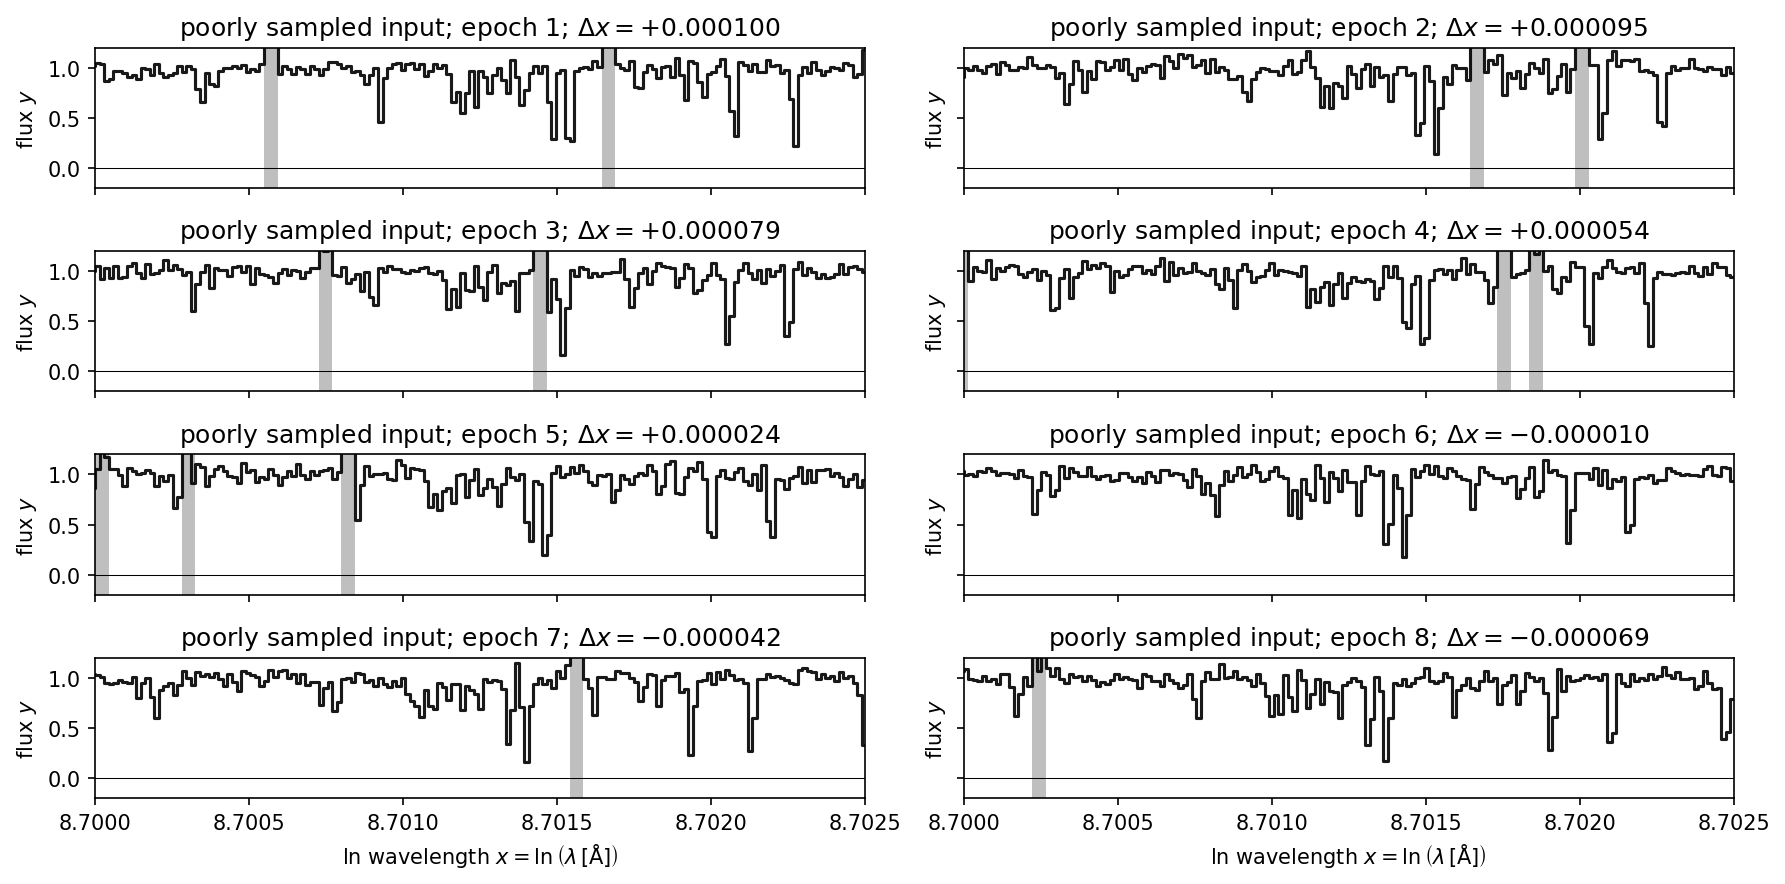

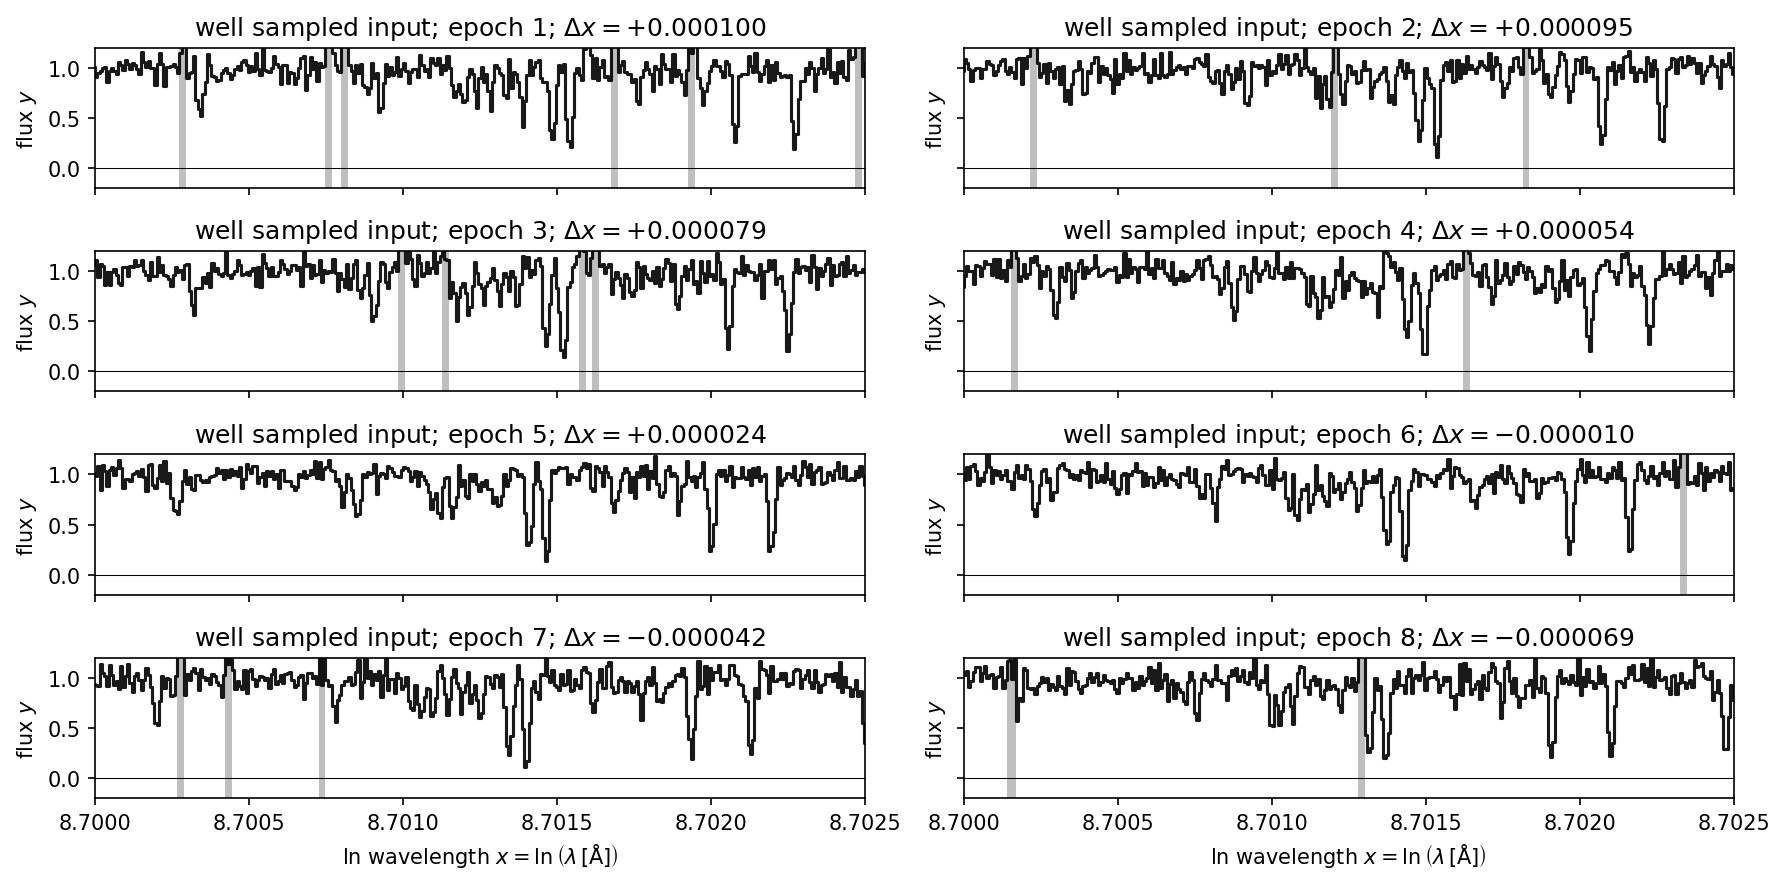

In [41]:
# show the input data
for N, xs, dx, ys, bs, Delta_xs, prefix, pfn \
        in [(N1, xs1, dx1, ys1, bs1, Delta_xs1, name1, "data1.pdf"),
            (N2, xs2, dx2, ys2, bs2, Delta_xs2, name2, "data2.pdf")]:
    fig, axes = plt.subplots(N // 2, 2, sharex=True, sharey=True,
                         figsize=(12., 0.75 * N))
    for j,ax in enumerate(axes.flatten()):
        ax.axhline(0., color="k", lw=0.5)
        ax.step(xs, ys[j], color="k", where="mid", alpha=0.9)
        ax.set_title(prefix + "; epoch {}; $\Delta x = {:+f}$".format(j + 1, Delta_xs[j]))
        ax.set_ylabel(r"flux $y$")
        for k in np.arange(len(ys[j]))[bs[j] < 0.5]:
            ax.fill_between([xs[k] - 0.5 * dx, xs[k] + 0.5 * dx],
                            [-1., -1.], [2., 2.], color="k", alpha=0.25, ec="none")
    for j in range(2):
        axes[-1, j].set_xlabel(xlabel)
    plt.xlim(x_min, x_max)
    ylim = (-0.2, 1.2)
    plt.ylim(*ylim)
    plt.savefig(pfn)

<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
/var/folders/r8/bk71hhjn6yzd4qpnmwrx9cjm0000gn/T/ipykernel_8062/374247654.py:19: SyntaxWarning: invalid escape sequence '\D'
  axes[0].set_title(name1 + "; epoch {}; $\Delta x = {:+f}$".format(j + 1, Delta_xs[j]))


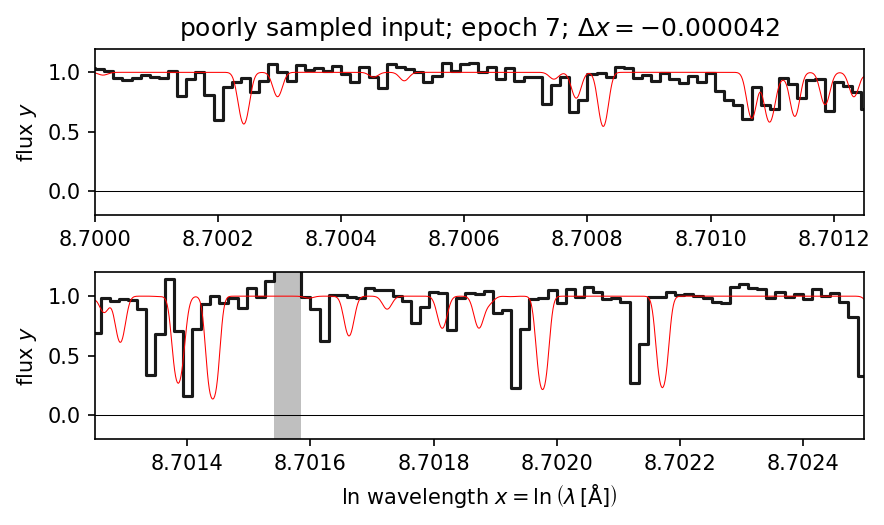

In [42]:
# zoom in on one epoch and compare it to the true template.
j = 6
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
finexs = np.arange(x_min - 1. / R, x_max + 1. / R, 1. / (5. * R))
for ax in axes:
    ax.axhline(0., color="k", lw=0.5)
    ax.step(xs1, ys1[j], color="k", where="mid", alpha=0.9)
    ax.set_ylabel(r"flux $y$")
    ax.plot(finexs, true_spectrum(finexs, 0.), "r-", alpha=1.0, lw=0.5)
    ax.ticklabel_format(useOffset=False)
    for k in np.arange(len(ys1[j]))[bs1[j] < 0.5]:
        ax.fill_between([xs1[k] - 0.5 * dx1, xs1[k] + 0.5 * dx1],
                        [-1., -1.], [2., 2.], color="k", alpha=0.25, ec="none")

axes[0].set_xlim(x_min, 0.5 * (x_max + x_min))
axes[1].set_xlim(0.5 * (x_max + x_min), x_max)
axes[0].set_ylim(*ylim)
axes[1].set_xlabel(xlabel)
axes[0].set_title(name1 + "; epoch {}; $\Delta x = {:+f}$".format(j + 1, Delta_xs[j]))
plt.savefig("datazoom.pdf")

## Set up output parameters and functions for combined spectrum.

Notes:
- If you set `P = Mstar` then the Fourier model can interpolate anything.
- If you set `P = Mstar // 2 + 1` then the Fourier model will be band-limited at the Nyquist frequency. This is cool but it shows ringing / wiggles.

In [43]:
def design_matrix(xs, P, L=(x_max - x_min)):
    """
    Take in a set of x positions and return the Fourier design matrix.

    ## Bugs:
    - Needs comment header.
    
    ## Comments:
    - The code looks different from the paper because Python zero-indexes.
    - This could be replaced with something that makes use of finufft.
    """
    X = np.ones_like(xs).reshape(len(xs), 1)
    for j in range(1, P):
        if j % 2 == 0:
            X = np.concatenate((X, np.cos(np.pi * j * xs / L)[:, None]), axis=1)
        else:
            X = np.concatenate((X, np.sin(np.pi * (j + 1) * xs / L)[:, None]), axis=1)
    return X

def pack_matrices(xs, ys, bs, Delta_xs, P):
    """
    Rearrange data into big matrices for `lstsq()`.

    ## Bugs:
    - Needs comment header.
    """
    XX = np.array([])
    YY = np.array([])
    for bb, yy, Dx in zip(bs, ys, Delta_xs):
        x_rest = (xs - Dx)[bb > 0.5]
        I = np.logical_and(x_rest > x_min, x_rest < x_max)
        YY = np.append(YY, yy[bb > 0.5][I])
        XX = np.append(XX, x_rest[I])
    return design_matrix(XX, P), YY

def Forward_Model_tm(xs, ys, bs, Delta_xs, P, xstar):
    """
    Do it all!
    
    ## Bugs:
    - Doesn't take the inverse variance on the data!
    - Doesn't return the inverse variance tensor for the output.
    """
    X, Y = pack_matrices(xs, ys, bs, Delta_xs, P)
    Xstar = design_matrix(xstar, P)
    thetahat, foo, bar, whatevs = np.linalg.lstsq(X, Y, rcond=None)
    return Xstar @ thetahat

## Make the combined spectrum and compare to the truth.

In [44]:
ystar1 = Forward_Model_tm(xs1, ys1, bs1, Delta_xs1, P, xstar)
ystar2 = Forward_Model_tm(xs2, ys2, bs2, Delta_xs2, P, xstar)

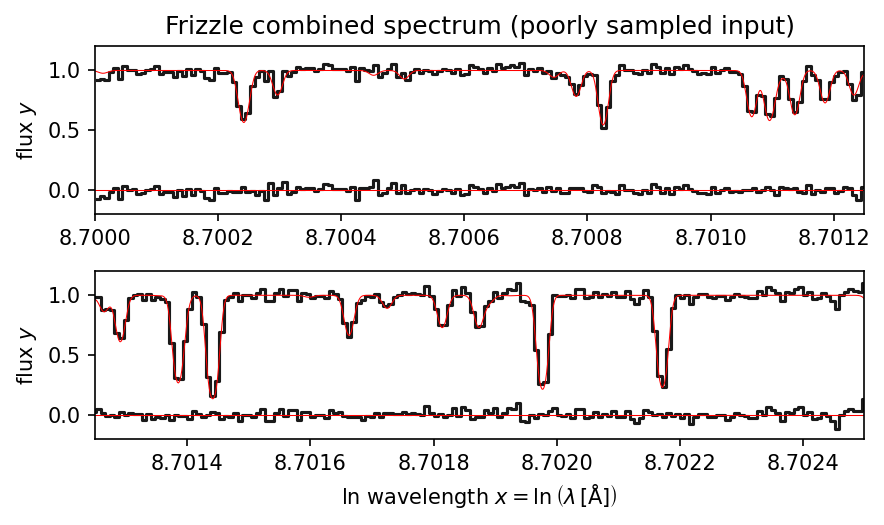

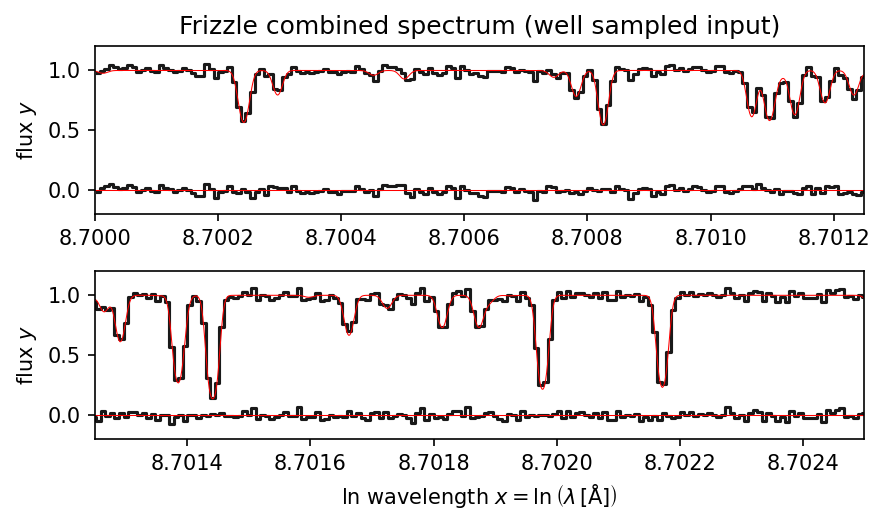

In [45]:
# compare the combined spectrum to the true template.
for ystar, name, pfn in [(ystar1, name1, "forward1.pdf"),
                         (ystar2, name2, "forward2.pdf")]:
    fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
    for ax in axes:
        ax.step(xstar, ystar, color="k", where="mid", alpha=0.9)
        ax.step(xstar, ystar - true_spectrum(xstar, 0.), color="k", where="mid", alpha=0.9)
        ax.set_ylabel(r"flux $y$")
        ax.plot(finexs, true_spectrum(finexs, 0.), "r-", lw=0.5)
        ax.axhline(0., color="r", lw=0.5)
        ax.ticklabel_format(useOffset=False)
    axes[0].set_xlim(x_min, 0.5 * (x_max + x_min))
    axes[1].set_xlim(0.5 * (x_max + x_min), x_max)
    axes[0].set_ylim(*ylim)
    axes[1].set_xlabel(xlabel)
    axes[0].set_title(frizzle_name + " combined spectrum ({})".format(name))
    plt.savefig(pfn)

## Implement a version of *Standard Practice (tm)*

In [46]:
def Hogg_Standard_Practice_tm(xs, ys, bs, Delta_xs, xstar, kind="cubic"):
    #interpolate the data and the masks; deal with edges.
    # Note that we are being very conservative with the mask.
    N = len(ys)
    yprimes = np.zeros((N, len(xstar)))
    bprimes = np.zeros_like(yprimes).astype(int)
    ikwargs = {"kind": kind, "fill_value": "extrapolate"}
    for j in range(N):
        yprimes[j] = interp.interp1d(xs - Delta_xs[j], ys[j],
                                     **ikwargs)(xstar)
        bprimes[j] = (np.abs(interp.interp1d(xs - Delta_xs[j], bs[j],
                                     **ikwargs)(xstar) - 1.) < 0.03).astype(int)
        bprimes[j][xstar < (min(xs) - Delta_xs[j])] = 0
        bprimes[j][xstar > (max(xs) - Delta_xs[j])] = 0
    ystar = np.sum(yprimes * bprimes, axis=0) / np.sum(bprimes, axis=0)
    return ystar, yprimes, bprimes


def Standard_Practice_tm(xs, ys, bs, Delta_xs, xstar, kind="cubic"):
    #interpolate the data and the masks; deal with edges.
    # Note that we are being very conservative with the mask.
    N = len(ys)
    yprimes = np.nan * np.ones((N, len(xstar)))
    bprimes = np.zeros_like(yprimes)
    ikwargs = {"kind": kind, "fill_value": np.nan, "bounds_error": False}
    for j in range(N):
        use = (bs[j] > 0.5)
        f = interp.interp1d(
            xs[use] - Delta_xs[j], 
            ys[j][use],
            **ikwargs
        )
        yprimes[j] = f(xstar)
        # include bs values in interpolation of just bprimes
        bprimes[j] = interp.interp1d(xs - Delta_xs[j], bs[j], **ikwargs)(xstar)

        
    ystar = np.nanmean(yprimes, axis=0)
    bprimes = np.mean(bprimes, axis=0)
    return ystar, yprimes, bprimes

In [47]:
# do the combination
ystar_sp1, yprimes1, bprimes1 = Standard_Practice_tm(xs1, ys1, bs1, Delta_xs1, xstar)
ystar_sp2, yprimes2, bprimes2 = Standard_Practice_tm(xs2, ys2, bs2, Delta_xs2, xstar)

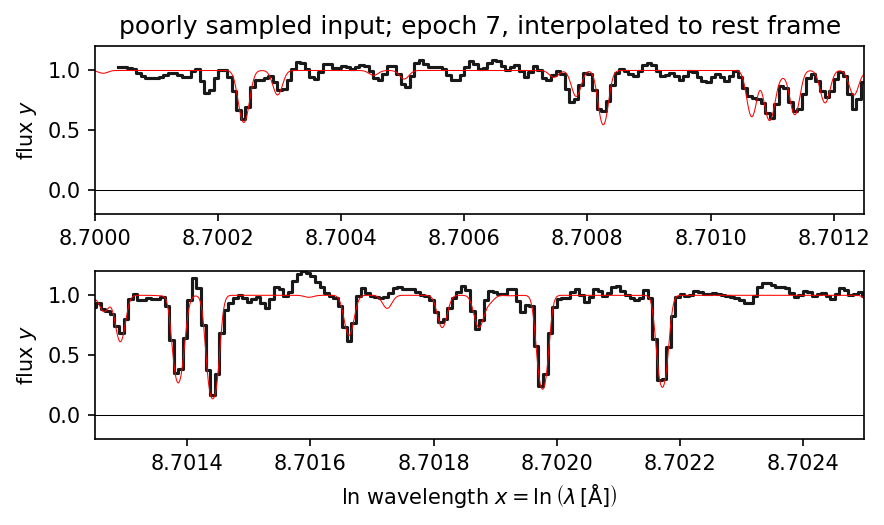

In [48]:
j = 6
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
for ax in axes:
    ax.axhline(0., color="k", lw=0.5)
    ax.step(xstar, yprimes1[j], color="k", where="mid", alpha=0.9)
    ax.set_ylabel(r"flux $y$")
    ax.plot(finexs, true_spectrum(finexs, 0.), "r-", alpha=1.0, lw=0.5)
    ax.ticklabel_format(useOffset=False)
    for k in np.arange(len(yprimes1[j]))[bprimes1[j] < 0.5]:
        ax.fill_between([xstar[k] - 0.5 * dxstar, xstar[k] + 0.5 * dxstar],
                        [-1., -1.], [2., 2.], color="k", alpha=0.25, ec="none")
axes[0].set_xlim(x_min, 0.5 * (x_max + x_min))
axes[1].set_xlim(0.5 * (x_max + x_min), x_max)
axes[0].set_ylim(*ylim)
axes[1].set_xlabel(xlabel)
axes[0].set_title(name1 + "; epoch {}, interpolated to rest frame".format(j + 1))
plt.savefig("datazoom_interpolated.pdf")

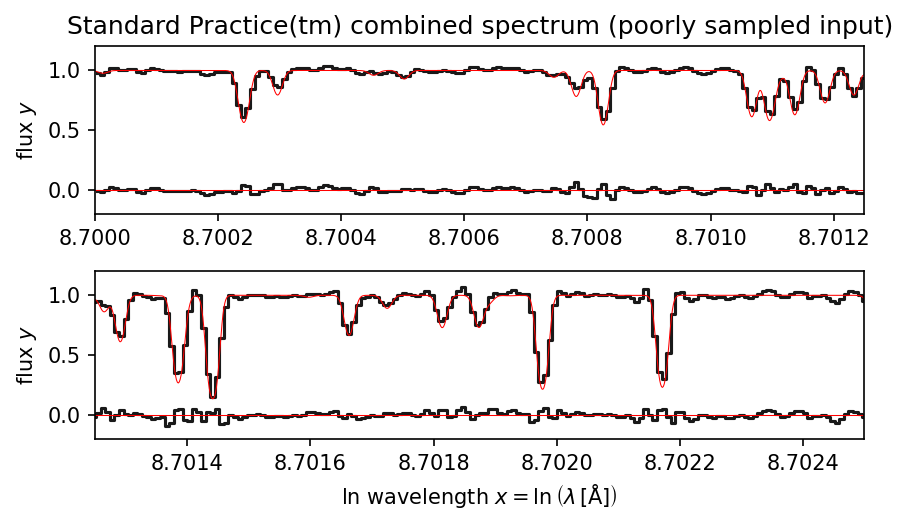

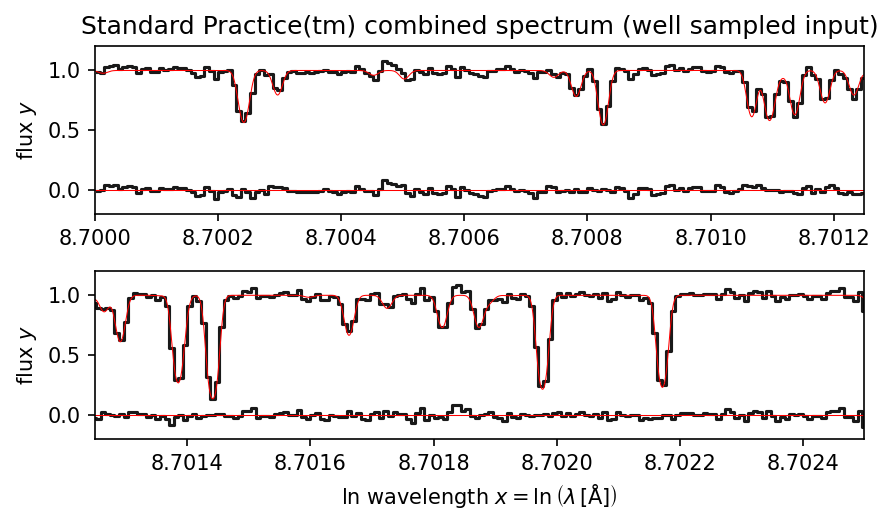

In [49]:
# compare the combined spectrum to the true template.
for ystar_sp, name, pfn in [(ystar_sp1, name1, "standard1.pdf"),
                            (ystar_sp2, name2, "standard2.pdf")]:
    fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
    for ax in axes:
        ax.step(xstar, ystar_sp, color="k", where="mid", alpha=0.9)
        ax.step(xstar, ystar_sp - true_spectrum(xstar, 0.), color="k", where="mid", alpha=0.9)
        ax.set_ylabel(r"flux $y$")
        ax.plot(finexs, true_spectrum(finexs, 0.), "r-", lw=0.5)
        ax.axhline(0., color="r", lw=0.5)
        ax.ticklabel_format(useOffset=False)
    axes[0].set_xlim(x_min, 0.5 * (x_max + x_min))
    axes[1].set_xlim(0.5 * (x_max + x_min), x_max)
    axes[0].set_ylim(*ylim)
    axes[1].set_xlabel(xlabel)
    axes[0].set_title(standard_name + " combined spectrum ({})".format(name))
    plt.savefig(pfn)

## Empirically compute pixel covariances as a function of lag

In [50]:
# Estimate covariances from just one trial:
def covariances(resids):
    lags = np.arange(12)
    var = np.zeros(len(lags)) + np.nan
    var[0] = np.mean(resids * resids)
    for lag in lags[1:]:
        var[lag] = np.mean(resids[lag:] * resids[:-lag])
    return lags, var

In [51]:
# Estimate using multiple repeated experiments
ntrial = 64
for i, dx, SNR in [(1, dx1, SNR1),
                   (2, dx2, SNR2)]:
    numerator = 0.
    numerator_sp = 0.
    for trial in range(ntrial):
        xs, ys, y_ivars, bs, Delta_xs = make_one_dataset(dx, SNR)
        ystar = Forward_Model_tm(xs, ys, bs, Delta_xs, P, xstar)
        ystar_sp, foo, bar = Standard_Practice_tm(xs, ys, bs, Delta_xs, xstar)
        lags, covars = covariances(ystar - true_spectrum(xstar, 0.))
        lags, covars_sp = covariances(ystar_sp - true_spectrum(xstar, 0.))
        numerator += covars
        numerator_sp += covars_sp
    if i == 1:
        covars1 = numerator / ntrial
        covars_sp1 = numerator_sp / ntrial
    elif i == 2:
        covars2 = numerator / ntrial
        covars_sp2 = numerator_sp / ntrial

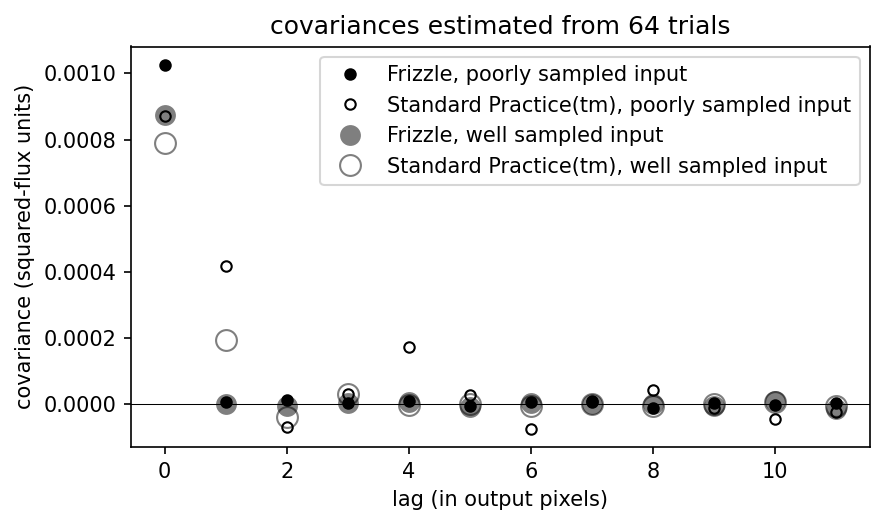

In [52]:
plt.axhline(0., color="k", lw=0.5)
plt.plot(lags, covars1, "ko", ms=5,
         label=frizzle_name + ", " + name1)
plt.plot(lags, covars_sp1, "ko", ms=5, mfc="none",
         label=standard_name + ", " + name1)
plt.plot(lags, covars2, "ko", ms=10, alpha=0.5, mec="none",
         label=frizzle_name + ", " + name2)
plt.plot(lags, covars_sp2, "ko", ms=10, alpha=0.5, mfc="none",
         label=standard_name + ", " + name2)
plt.legend()
plt.xlabel("lag (in output pixels)")
plt.ylabel("covariance (squared-flux units)")
plt.title("covariances estimated from {} trials".format(ntrial))
plt.savefig("noise.pdf")